In [1]:
using Colors
using CSV
using DataFrames
using Plots
using StatsBase: mean

include("../src/ColorScheme.jl")
using .ColorScheme: DARK_RED, LIGHT_RED, GRAY, LIGHT_BLUE, DARK_BLUE, COLOR_GRAD

println("Julia $(VERSION)")
println("Thread count: $(Threads.nthreads())")

Julia 1.10.2
Thread count: 12


In [2]:
default(
    fontfamily="serif-roman",
    titlefontsize=16,
    guidefontsize=14,
    tickfontsize=11,
    legendfontsize=11,
    margin=5Plots.mm,
    lw=2.0,
    marker=:circle,
    markerstrokewidth=0,
);

In [3]:
FILE_NAMES = [
    "../output/CircleModel_20240826_144719.csv",  # σR ∈ 0:49, 10 trials
    "../output/CircleModel_20240826_182404.csv",  # σR ∈ 0:49, 10 trials
    "../output/CircleModel_20240826_200917.csv",  # β ∈ 0.0:0.1:0.9, sigmaθ ∈ {0.01, 0.1, 0.2, 0.3}, 10 trials
    "../output/CircleModel_20240828_113854.csv",  # β ∈ 0.0:0.1:0.9, sigmaθ ∈ {0.01, 0.1, 0.2, 0.3}, 10 trials
    "../output/CircleModel_20240828_191857.csv",  # β ∈ 0.0:0.1:0.9, sigmaθ ∈ {0.01, 0.1, 0.2, 0.3}, 10 trials
    "../output/CircleModel_20240827_170414.csv",  # combination, 10 trials
    "../output/CircleModel_20240827_181750.csv",  # combination, 10 trials
    # "../output/CircleModel_20240827_100534.csv",  # all, 10 trials
    "../output/CircleModel_20240827_215238.csv",  # all, 10 trials
    "../output/CircleModel_20240828_213318.csv",  # all, 10 trials
    "../output/CircleModel_20240829_093929.csv",  # all, 10 trials
    "../output/CircleModel_20240829_154557.csv",  # all, 10 trials
    "../output/CircleModel_20240829_210419.csv",  # all, 10 trials
];

In [4]:
dfs = [DataFrame(CSV.File(n)) for n in FILE_NAMES]
df = vcat(dfs...);

In [5]:
regional_var_df = df[
    df.C_rate₀ .== 0.0 .&&
    df.resource_limit_β .== 0.0 .&&
    df.resource_limit_σ .== 0.0, :]

universal_var_df = df[
    df.C_rate₀ .== 0.0 .&&
    df.peak_node_variability .== 0 .&&
    df.resource_limit_σ .!= 0.0, :]

@show size(regional_var_df)
@show size(universal_var_df)

groupby_combine_sort(df::DataFrame, keys::Vector)::DataFrame = sort(combine(groupby(df, keys), :cooperation_rate => mean => :cooperation_rate))

regional_var_df = groupby_combine_sort(regional_var_df, [:relationship_increment_factor, :b, :peak_node_variability])
universal_var_df = groupby_combine_sort(universal_var_df, [:relationship_increment_factor, :b, :resource_limit_β, :resource_limit_σ])

@show size(regional_var_df)
@show size(universal_var_df);

size(regional_var_df) = (11550, 17)
size(universal_var_df) = (10560, 17)
size(regional_var_df) = (1650, 4)
size(universal_var_df) = (1320, 5)


In [6]:
function line_color(fRI::Float64)::String
    return if fRI == 1.2
        "#B32034"  # Deep Red
    elseif fRI == 1.1
        "#2D579A"  # Deep Blue
    else
        "#000000"  # Black
    end
end

function line_marker(fRI::Float64)::Symbol
    return if fRI == 1.2
        :circle
    elseif fRI == 1.1
        :utriangle
    else
        :x
    end
end;

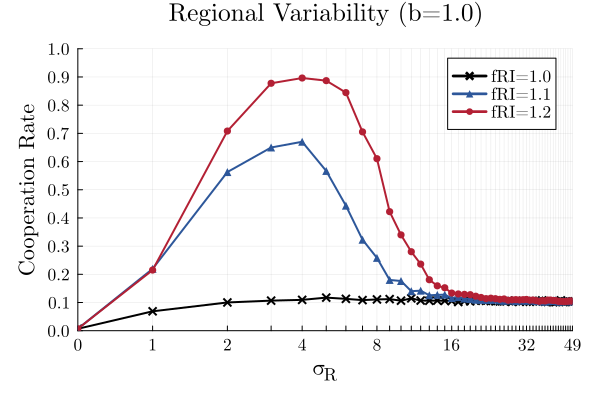

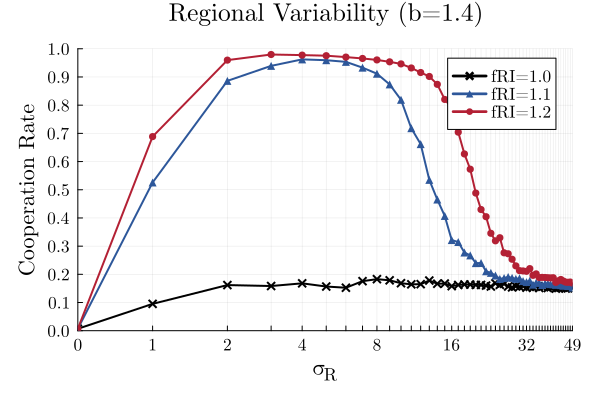

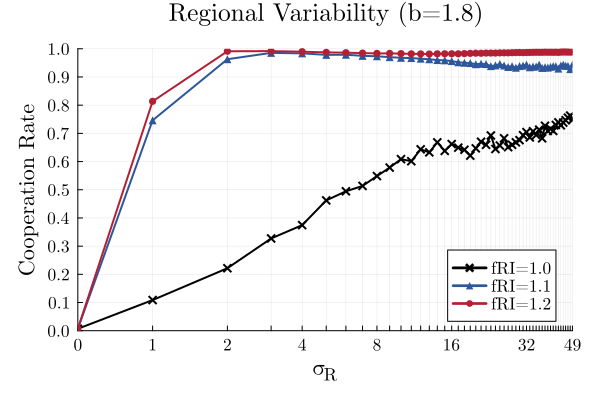

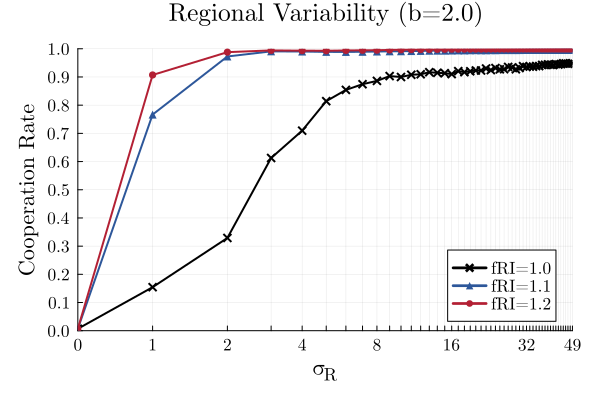

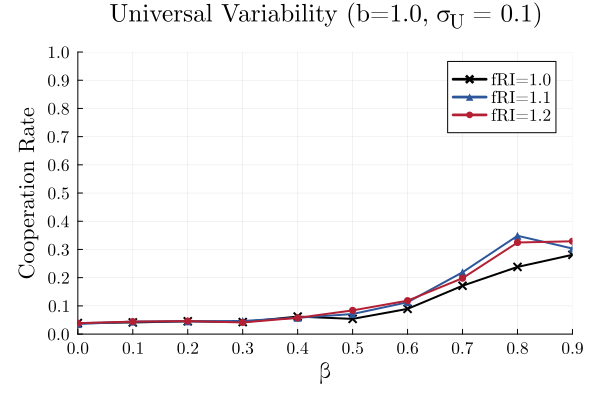

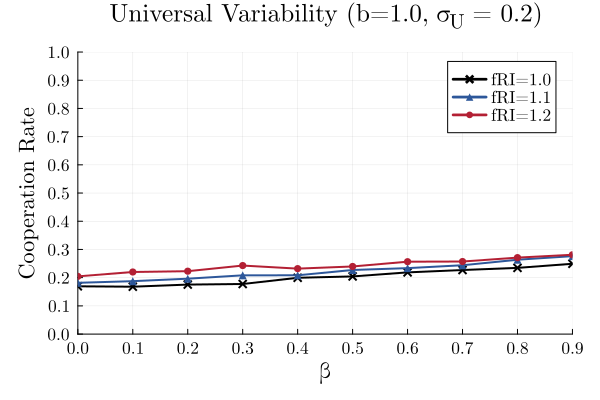

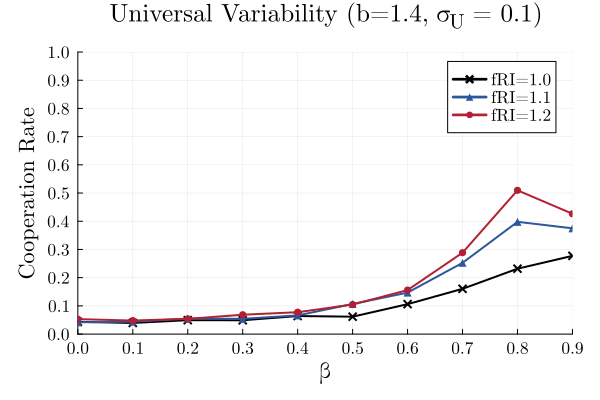

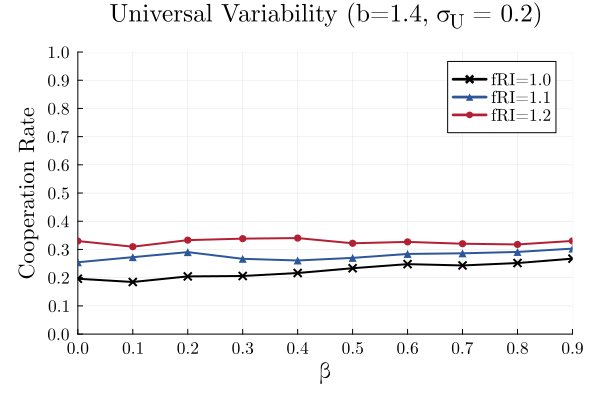

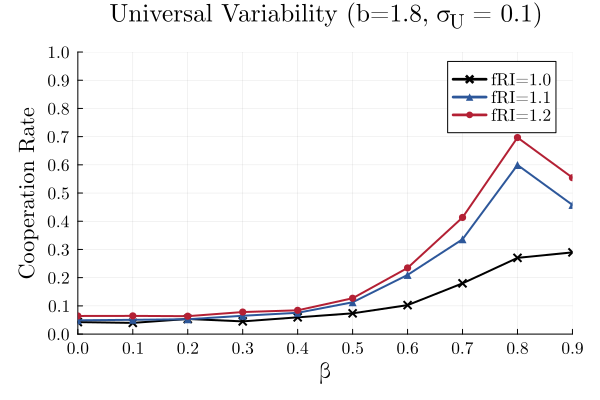

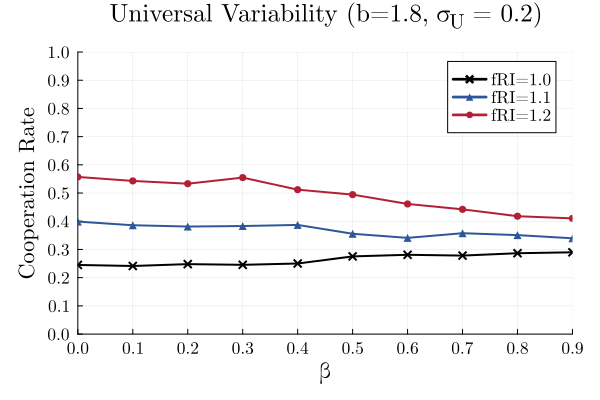

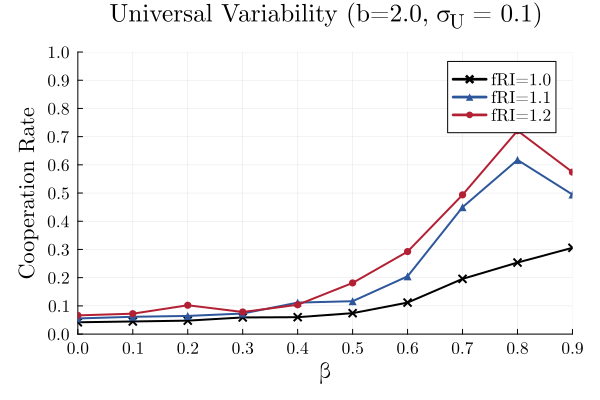

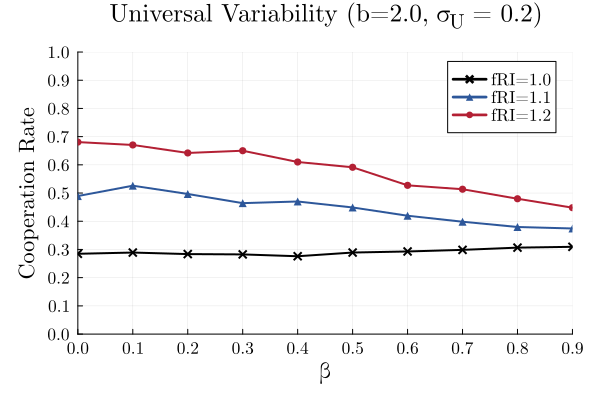

In [18]:
function plot_regional(df::DataFrame, b::Float64)::Nothing
    _df = df[df.b .== b, :]
    _df.peak_node_variability = Float64.(_df.peak_node_variability)
    replace!(_df.peak_node_variability, 0 => 0.5)
    xticks = sort(unique(_df.peak_node_variability))
    xticks_label = [x in [1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 49.0] ? "$(Int(x))" : "" for x in xticks]
    xticks_label[1] = "0"

    p = plot(
        xticks=(xticks, xticks_label),
        xscale=:log2,
        xlim=(0.5, 49),
        xlabel="\\sigma_R",
        yticks=0:0.1:1,
        ylim=(0, 1),
        ylabel="Cooperation Rate",
        # legend=:bottomright,
        tickfont = "serif-roman",
        title="Regional Variability (b=$(b))",
    )

    for __df in groupby(_df, [:relationship_increment_factor])
        fRI = __df.relationship_increment_factor[1]
        plot!(__df.peak_node_variability, __df.cooperation_rate, label="fRI=$(fRI)", lc=line_color(fRI), mc=line_color(fRI), marker=line_marker(fRI))
    end

    display(p)
    savefig("img/fig5_Regional_$(b).png")

    return
end

function plot_universal(df::DataFrame, b::Float64, σ::Float64)::Nothing
    _df = df[df.b .== b .&& df.resource_limit_σ .== σ, :]
    β_vec = sort(unique(_df.resource_limit_β))

    p = plot(
        xticks=β_vec,
        xlim=(minimum(β_vec), maximum(β_vec)),
        yticks=0:0.1:1.0,
        ylim=(0, 1.0),
        xlabel="\\beta",
        ylabel="Cooperation Rate",
        title="Universal Variability (b=$(b), \\sigma_{U} = $(σ))",
    )

    for __df in groupby(_df, [:relationship_increment_factor])
        fRI = __df.relationship_increment_factor[1]
        plot!(__df.resource_limit_β, __df.cooperation_rate, label="fRI=$(fRI)", lc=line_color(fRI), mc=line_color(fRI), marker=line_marker(fRI))
    end

    display(p)
    savefig("img/fig5_Universal_$(b)_$(σ).png")

    return
end

b_vec = [1.0, 1.4, 1.8, 2.0]
σ_vec = [0.1, 0.2]

for b in b_vec
    plot_regional(regional_var_df, b)
end

for b in b_vec, σ in σ_vec
    plot_universal(universal_var_df, b, σ)
end;